In [ ]:
#@title Common Import and Configuration { display-mode: "form" }
from ipywidgets import widgets
from IPython.display import display

from math import sqrt
from os.path import exists

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import kurtosis, skew

import statsmodels.api as sm


from sklearn.model_selection import cross_validate

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from numpy import mean
from numpy import std

from yellowbrick.target import FeatureCorrelation
from sklearn.preprocessing import OrdinalEncoder

from google.colab import drive
from IPython.display import clear_output 
from google.colab import data_table

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from ipywidgets import Label
from IPython.display import display, HTML
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
import statsmodels.api as sm
drive.mount('/content/drive/')
dfpath = "/content/drive/Shareddrives/ICAIML_Project/ICAIML/Datasets"

Mounted at /content/drive/


In [ ]:
#@title Prepare Data

path = "/content/drive/Shareddrives/DA224-O/project/data" 

selecteddf = path +"/"+ "train.csv"
df = None

df = pd.read_csv(selecteddf)

df = df.drop(["Unnamed: 0"], axis = 1)
dfcols = df.columns
typs = df.dtypes
dfcols = list(dfcols)

dfbackup = df.copy()

target = 'HeartDisease'

catCols = []
numCols = []
tarCol = []
isRegression = True
typs = df.dtypes
#uniqRatio = []
for items in typs.iteritems():
    #print(items[0], items[1])
    if df[items[0]].count() == 0:
      continue
    #print(items[0], len(df[items[0]].unique()), len(df[items[0]].unique()) > 99)
    uRatio = len(df[items[0]].unique())/df[items[0]].count()

    if (items[1] == 'object' or items[1] == 'category' or items[1] == 'bool'):
      if (target == items[0]):
        isRegression = False
        tarCol.append(items[0])
      else:
        catCols.append(items[0])
    else:
      #uniqRatio.append((items, uRatio)
      isNum = (df[items[0]].count() > 1000 and uRatio > 0.005) or (df[items[0]].count() < 1000 and uRatio > 0.1) or (len(df[items[0]].unique()) > 99)

      if (isNum):
        if (target == items[0]):
          tarCol.append(items[0])
        else:
          numCols.append(items[0])
      else:
        if (target == items[0]):
          isRegression = False
          tarCol.append(items[0])
        else:
          catCols.append(items[0])
probtype = ""
if isRegression:
  probtype = "Regression Problem"
else:
  probtype = "Classification Problem"


## EDA: Plots and Analysis

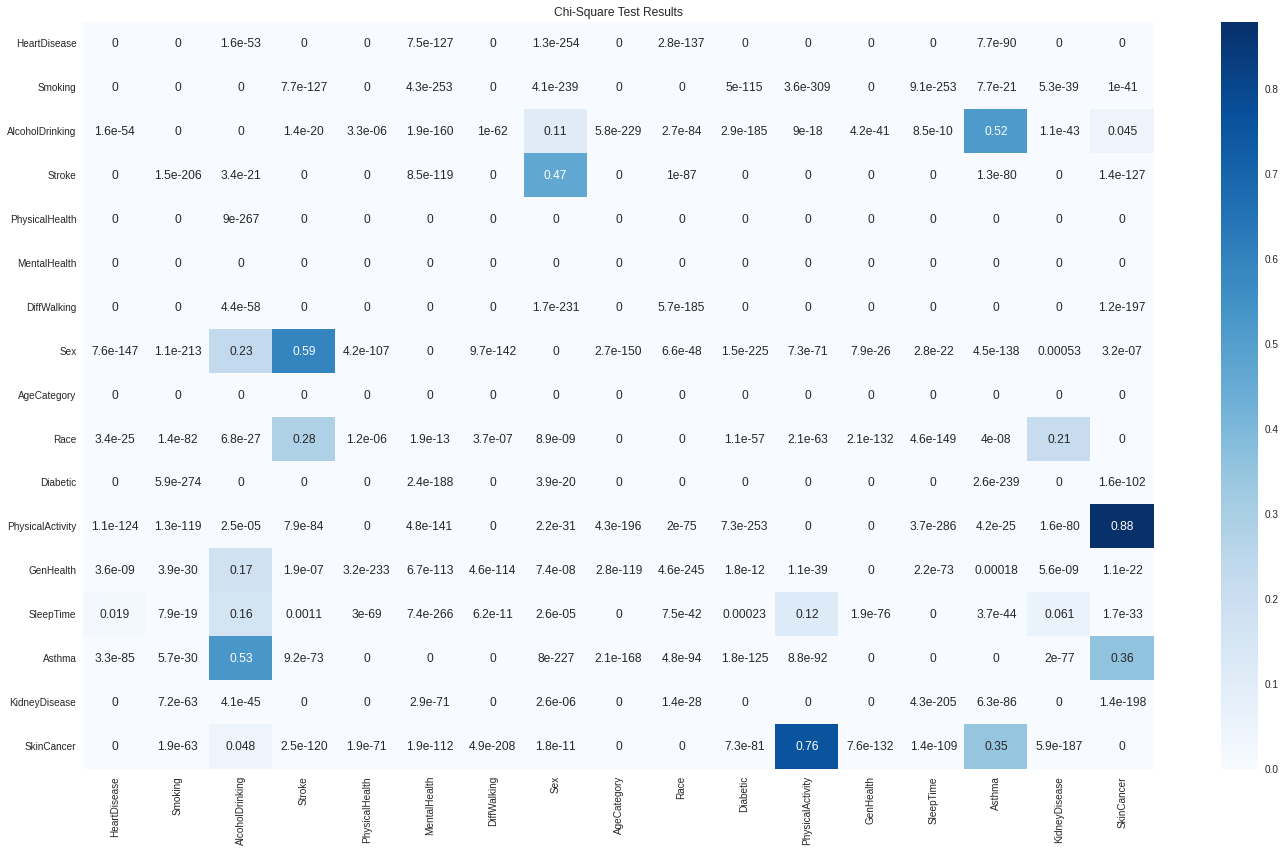

In [ ]:
from sklearn.feature_selection import chi2

#@title Run and Select EDA Plot to Display { display-mode: "form" }
cols = ["Correlation Heatmap", "Histogram", "Correlation with Target", "Count Plot(Categorical)", 
        "Box Plot (Numerical)", "Violin Plot", "QQ Plot",
        "Mutual Information"]
def Chi2(df):
  df = df.drop(['BMI'], axis=1)
  resultant = pd.DataFrame(data=[(0 for i in range(len(df.columns))) for i in range(len(df.columns))], 
                          columns=list(df.columns))
  resultant.set_index(pd.Index(list(df.columns)), inplace = True)

  # Finding p_value for all columns and putting them in the resultant matrix
  for i in list(df.columns):
      for j in list(df.columns):
          if i != j:
              chi2_val, p_val = chi2(np.array(df[i]).reshape(-1, 1), np.array(df[j]).reshape(-1, 1))
              resultant.loc[i,j] = p_val

  fig = plt.figure(figsize=(20,12))
  sns.heatmap(resultant, cmap='Blues', annot=True)
  plt.title('Chi-Square Test Results')
  plt.tight_layout()
  plt.savefig('chi2.png', dpi=300, bbox_inches='tight')

def CorrelationHM(df):
  plt.figure(figsize=(12, 8))
  ###########NOTE: Here, the logic should be based on the value chose 
  if (len(df.columns) < 20):
    heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap="YlGnBu", annot=True)
  else:
    heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap="YlGnBu")

  heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12)
  plt.tight_layout()
  plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')
 
def Histogram(df):

  df.hist(bins=25,figsize=(20,15))
  plt.tight_layout()
  plt.savefig('Histogram.png', dpi=300, bbox_inches='tight')

def Countplot(df, catCols):
  if (len(catCols) == 0):
    return
  height = int(len(catCols)/3) if len(catCols)%3 == 0 else (int(len(catCols)/3) + 1)
  width = 3 if len(catCols) >= 3 else len(catCols)
  figure, axes = plt.subplots(height, width, figsize=(width*5, height*4))

  index = 0
  for f,ax in zip(catCols, axes.ravel()):
      sns.countplot(df[f], ax=ax)
      plt.setp(ax.get_xticklabels(), rotation=45, fontsize=7)

  #plt.xticks(rotation = 45)
  figure.tight_layout()
  plt.savefig('Countplot.png', dpi=300, bbox_inches='tight')


def Boxplot(df, catCols):
  if (len(catCols) == 0):
    return
  height = int(len(catCols)/3) if len(catCols)%3 == 0 else int(len(catCols)/3) + 1
  width = 3 if len(catCols) >= 3 else len(catCols)+1
  figure, axes = plt.subplots(height, width, figsize=(width*5, height*4))

  for f,ax in zip(catCols, axes.ravel()):
      sns.boxplot(df[f], ax=ax)
      plt.setp(ax.get_xticklabels(), rotation=45)

  #plt.xticks(rotation = 45)
  figure.tight_layout()
  plt.savefig('Boxplot.png', dpi=300, bbox_inches='tight')

def Violinplot(df, catCols, target):
  if (len(catCols) == 0):
    return
  global isRegression
  height = int(len(catCols)/3) if len(catCols)%3 == 0 else int(len(catCols)/3) + 1
  width = 3 if len(catCols) >= 3 else len(catCols)+1
  figure, axes = plt.subplots(height, width, figsize=(width*5, height*4))

  for f,ax in zip(catCols, axes.ravel()):
      if isRegression:
        sns.violinplot(x=df[f], ax=ax)
      else:
        sns.violinplot(x=df[target], y=df[f], ax=ax)
      #plt.setp(ax.get_xticklabels(), rotation=45)

  #plt.xticks(rotation = 45)
  figure.tight_layout()
  plt.savefig('Violinplot.png', dpi=300, bbox_inches='tight')

def QQPlot(df, dfcols, target):
  if (len(dfcols) == 0):
    return
  fig, axs = plt.subplots(len(dfcols), 2,
                        figsize=(10, len(df.columns)*6))

  for i, col in enumerate(dfcols):
      sns.histplot(df[col], ax=axs[i, 0])
      sm.qqplot(df[col].dropna(), line="s", ax=axs[i, 1], fmt='b')
      axs[i, 1].set_title(col)

def Correlation_Target_Heatmap(df, target):
  plt.figure(figsize=(12, 8))
  heatmap = sns.heatmap(df.corr()[[target]].sort_values(by=target, ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
  title = 'Features Correlating with ' + target 
  heatmap.set_title(title, fontdict={'fontsize':18}, pad=16);
  
  plt.tight_layout()
  plt.savefig('heatmapTarget.png', dpi=300, bbox_inches='tight')

def Correlation_Target(df, target):
  df_features = df.drop(target, axis=1) # drop labels for training set
  df_labels = df[target].copy() 
  
  plt.figure(figsize=(10, 5))
  featurelist= df_features.columns
  features = np.array(featurelist)

  visualizer = FeatureCorrelation(labels=features, color='Orange', sort=True)
  visualizer.fit(df_features, df_labels)
  plt.savefig('Pearson_correlation.png', dpi=300, bbox_inches='tight')
  plt.tight_layout()
  visualizer.show()

def Mutual_Information(df, target):
  df_features = df.drop(target, axis=1) # drop labels for training set
  df_labels = df[target].copy()
 
  plt.figure(figsize=(10, 5))
  featurelist= df_features.columns
  features = np.array(featurelist)

  visualizer = FeatureCorrelation(labels=features, color='Green',method='mutual_info-classification', sort=True)
  visualizer.fit(df_features, df_labels, random_state=42)
  plt.savefig('Mutual_Information.png', dpi=300, bbox_inches='tight')
  plt.tight_layout()
  visualizer.show()


ord_enc = OrdinalEncoder()
#df = df.fillna(method="bfill").fillna(method="ffill")

for col in catCols:
  #convert the datatype uniformly in case of mismatched datatype
  df[col] = [str(int(x)) if isinstance(x, int) else x for x in df[col]]
  df[col] = df[col].astype('category')
  df[col] = ord_enc.fit_transform(df[[col]])

if isRegression != True:
  df[target] =  df[target].astype('category')
  df[target] = ord_enc.fit_transform(df[[target]])

def on_button_clicked(b):
  clear_output()
  selected = edas.value
  if (selected == cols[0]):
    Chi2(df)
  elif (selected == cols[1]):
    Histogram(df)
  elif (selected == cols[2]):
    Correlation_Target_Heatmap(df, target)
  elif (selected == cols[3]): #Passing backup Dataframe for printing un-encoded values
    Countplot(dfbackup, catCols)
  elif (selected == cols[4]):
    Boxplot(df, numCols)
  elif (selected == cols[5]):
    Violinplot(df, dfcols, target)
  elif (selected == cols[6]):
    QQPlot(df, dfcols, target)
  elif (selected == cols[7]):
    Mutual_Information(df, target)

edas = widgets.Dropdown(
    options=cols,
    value=cols[0],
    description='Select EDA: ',
    disabled=False,
)

okbutton = widgets.Button(
    description='OK',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)

it = [edas, okbutton]
box = widgets.Box(children=it)

okbutton.on_click(on_button_clicked)

display(box)
